# Berlin Open Data: Kitas

In this notebook I want to explore some data I found on the Berlin open data portal [https://daten.berlin.de/](https://daten.berlin.de/). The [data source](https://daten.berlin.de/datensaetze/kitas-berlin) contains informations of Kitas (Kindertagesstätte, i.e. kindergartens) in Berlin. This is a big topic as findng a spot in a Kita is extrmely difficult.

## Prepare Notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

## Read Data

Let us load the data from the orignial Excel file (which I store locally). 

In [2]:
kitas_raw_df = pd.read_excel(io='../Data/kitaliste_aktuell.xlsx', skiprows=4)

In [3]:
kitas_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2739 entries, 0 to 2738
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Betreuungsbezirk Nr  2739 non-null   int64  
 1   Betreuungsbezirk     2739 non-null   object 
 2   Einrichtungsnummer   2739 non-null   int64  
 3   Einrichtungsname     2739 non-null   object 
 4   Einrichtungsadresse  2739 non-null   object 
 5   PLZ                  2739 non-null   int64  
 6   Ort                  2739 non-null   object 
 7   Telefon              2708 non-null   object 
 8   Anzahl Plätze        2736 non-null   float64
 9   Einrichtungsart      2739 non-null   object 
 10  Trägernummer         2739 non-null   int64  
 11  Trägername           2739 non-null   object 
 12  Trägerart            2739 non-null   object 
dtypes: float64(1), int64(4), object(8)
memory usage: 278.3+ KB


In [4]:
kitas_raw_df['Ort'].unique()

array(['Berlin'], dtype=object)

In [5]:
kitas_raw_df[['Betreuungsbezirk Nr', 'Betreuungsbezirk']].drop_duplicates()

,Betreuungsbezirk Nr,Betreuungsbezirk
0,1,Mitte
329,2,Friedrichshain-Kreuzberg
620,3,Pankow
994,4,Charlottenburg-Wilmersdorf
1261,5,Spandau
1403,6,Steglitz-Zehlendorf
1602,7,Tempelhof-Schöneberg
1863,8,Neukölln
2096,9,Treptow-Köpenick
2287,10,Marzahn-Hellersdorf


## Format Data

In [6]:
rename_cols = {
    'Betreuungsbezirk': 'district',
    'Einrichtungsnummer': 'id',
    'Einrichtungsname': 'name',
    'Einrichtungsadresse': 'address',
    'PLZ': 'plz',                  
    'Telefon': 'telephone',       
    'Anzahl Plätze': 'spots'  ,
    'Einrichtungsart': 'type',
    'Trägernummer': 'carrier_number',
    'Trägername': 'carrier_name',  
    'Trägerart': 'carrier_type',
}

kitas_df = kitas_raw_df \
    .copy() \
    .drop(['Betreuungsbezirk Nr', 'Ort'], axis=1) \
    .rename(columns=rename_cols) \
    .assign(num_kitas_plz=lambda x: x.groupby(['district', 'plz'])['id'].transform('count'))
    
kitas_df.head()

,district,id,name,address,plz,telephone,spots,type,carrier_number,carrier_name,carrier_type,num_kitas_plz
0,Mitte,1010010,Kita F.A.I.R.play,Albrechtstr. 020,10117,281 64 73,69.0,Kindertagesstätte,1224,GFJ - gemeinnützige Gesellschaft für Familien-...,Sonstiger freier Träger,21
1,Mitte,1010020,Kita Kinderwelt,An der Kolonnade 003-5,10117,2291378,155.0,Kindertagesstätte,1334,Forum Soziale Dienste GmbH,Sonstiger freier Träger,21
2,Mitte,1010030,FRÖBEL Kindergarten Casa Fantasia,Anklamer Str. 038,10115,4498171,69.0,Kindertagesstätte,1227,Fröbel Bildung und Erziehung gGmbH,Sonstiger freier Träger,24
3,Mitte,1010080,Kita Regenbogen,Fehrbelliner Str. 080,10119,449 32 38,91.0,Kindertagesstätte,1202,Pfefferwerk Stadtkultur gGmbH,Sonstiger freier Träger,11
4,Mitte,1010100,"FRÖBEL Kindergarten ""Schatzinsel""",Fischerinsel 008,10179,201 37 88,241.0,Kindertagesstätte,1227,Fröbel Bildung und Erziehung gGmbH,Sonstiger freier Träger,10


## EDA

Let us get the number of unique values per feature. 

In [7]:
kitas_df.apply(lambda x: x.unique().size, axis=0)

district            12
id                2739
name              2597
address           2707
plz                190
telephone         2601
spots              200
type                 4
carrier_number    1224
carrier_name      1224
carrier_type         8
num_kitas_plz       37
dtype: int64

### Kitas per District

We see that there are Kitas with the same name but which are not the same. We have **2739 Kitas** ni our data set. Let us see their distrbuton over districts:

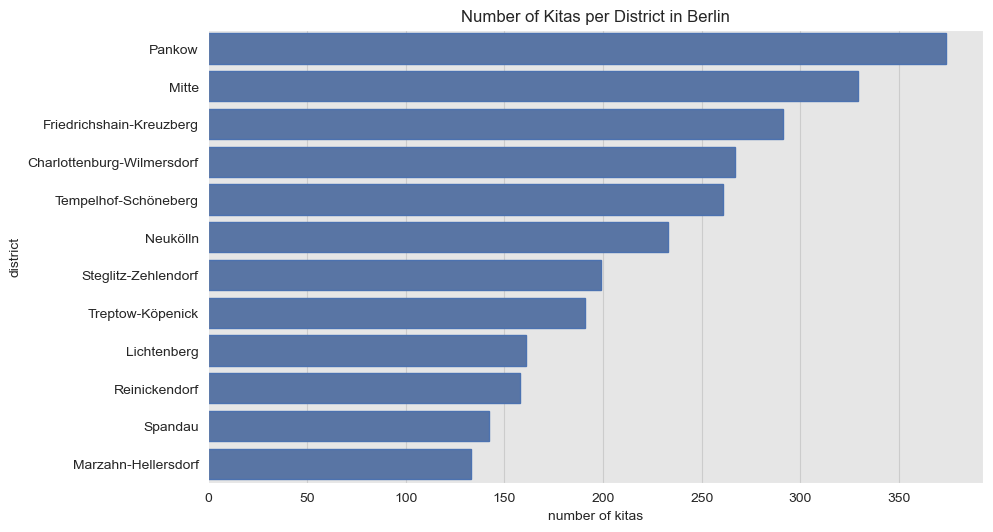

In [8]:
fig, ax = plt.subplots()

kitas_df \
    .groupby(['district']) \
    .agg(n=('id', 'count')) \
    .reset_index(drop=False) \
    .sort_values('n', ascending=False) \
    .pipe((sns.barplot, 'data'), 
        x='n', 
        y='district',
        color=sns_c[0],
        edgecolor=sns_c[0],
        ax=ax
    )
ax.set(
    title='Number of Kitas per District in Berlin', 
    xlabel='number of kitas', 
    ylabel='district'
);

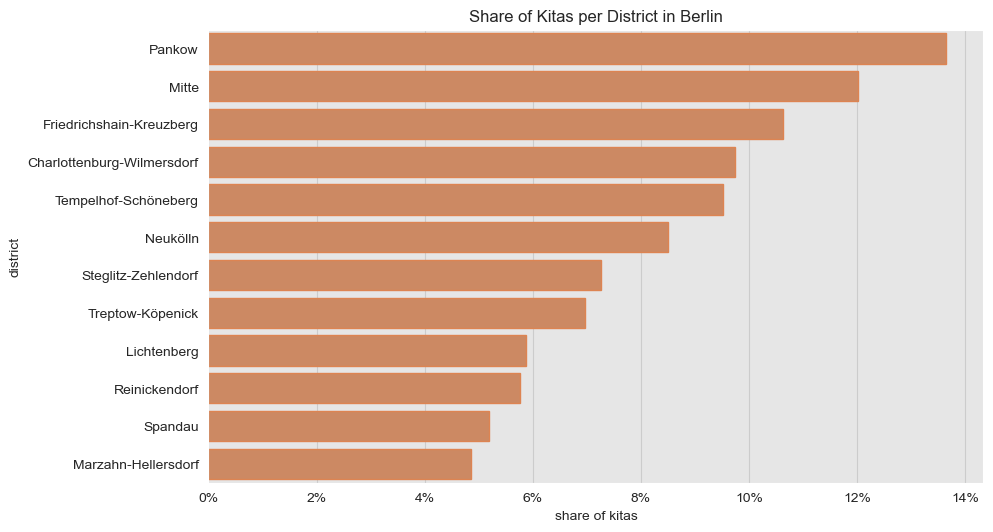

In [9]:
fig, ax = plt.subplots()

kitas_df \
    .groupby(['district']) \
    .agg(n=('id', 'count')) \
    .assign(share= lambda x: x['n'] / x['n'].sum()) \
    .reset_index(drop=False) \
    .sort_values('n', ascending=False) \
    .pipe((sns.barplot, 'data'), 
        x='share', 
        y='district',
        color=sns_c[1],
        edgecolor=sns_c[1],
        ax=ax
    )
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:0.0%}'.format(y)))
ax.set(
    title='Share of Kitas per District in Berlin', 
    xlabel='share of kitas', 
    ylabel='district'
);

### Kitas per PLZ

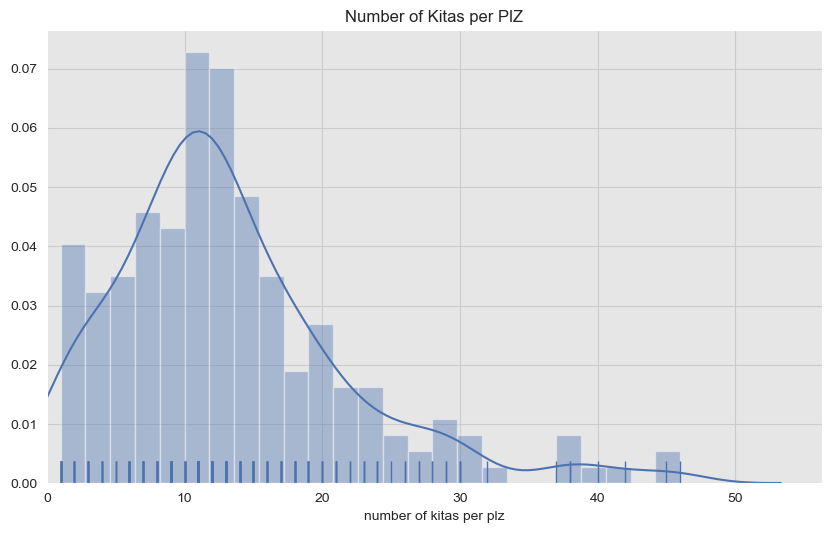

In [10]:
fig, ax = plt.subplots()

kitas_df \
    .groupby(['district', 'plz']) \
    .agg(n=('name', 'count')) \
    ['n'] \
    .pipe((sns.distplot, 'a'), 
        bins=25,
        rug=True, 
        ax=ax
    )
ax.set(
    title='Number of Kitas per PlZ', 
     xlabel='number of kitas per plz',
     xlim=(0, None)
);

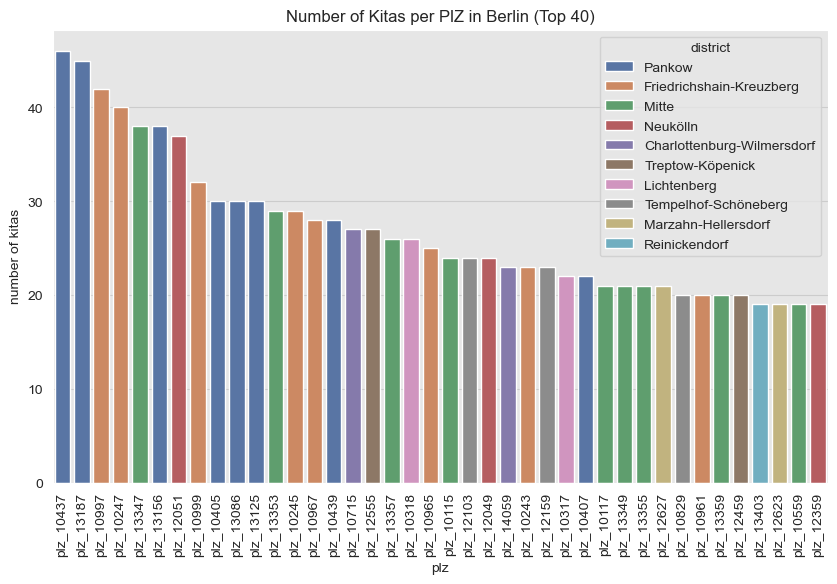

In [11]:
fig, ax = plt.subplots()

kitas_df \
    .groupby(['district', 'plz']) \
    .agg(n=('name', 'count')) \
    .reset_index(drop=False) \
    .assign(plz = lambda x: 'plz_' + x['plz'].astype(str)) \
    .sort_values('n', ascending=False) \
    .head(40) \
    .pipe((sns.barplot, 'data'),  
        x='plz',
        y='n',
        hue='district',
        dodge=False,
        ax=ax
    )
ax.tick_params(axis='x', labelrotation=90)
ax.set(
    title='Number of Kitas per PlZ in Berlin (Top 40)', 
     xlabel='plz', 
     ylabel='number of kitas', 
);

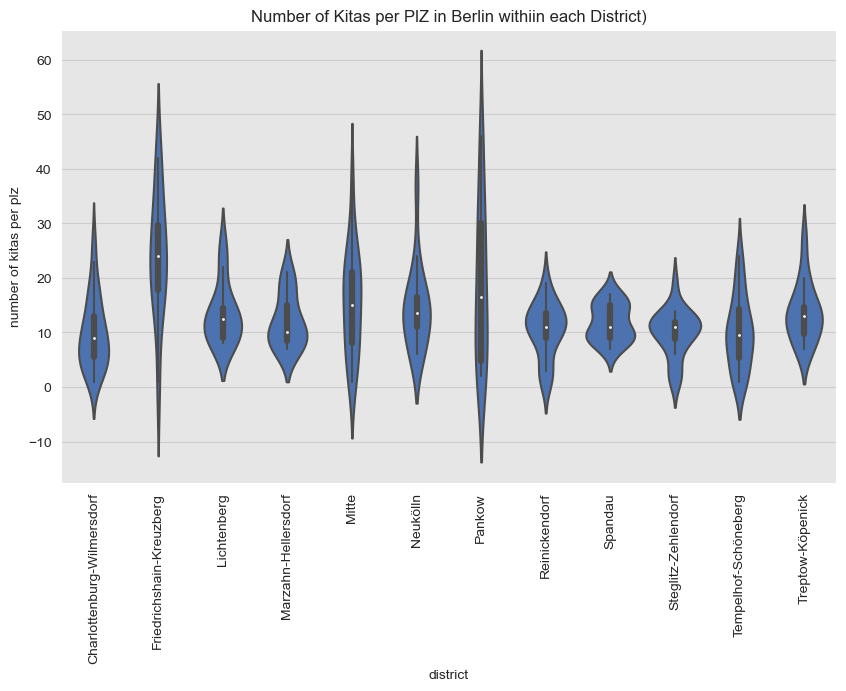

In [12]:
fig, ax = plt.subplots()

kitas_df \
    .groupby(['district', 'plz']) \
    .agg(n=('name', 'count')) \
    .reset_index(drop=False) \
    .pipe((sns.violinplot, 'data'), 
        x='district', 
        y='n',
        color=sns_c[0],
        saturation=1.0,
        ax=ax
    )

ax.tick_params(axis='x', labelrotation=90)
ax.set(
    title='Number of Kitas per PlZ in Berlin withiin each District)', 
     ylabel='number of kitas per plz', 
);

### Spots per Kita

Let us now analize the number of spots data. 

In [13]:
kitas_df['spots'].describe()

count    2736.000000
mean       67.617690
std        55.624663
min         0.000000
25%        25.000000
50%        45.000000
75%        95.000000
max       320.000000
Name: spots, dtype: float64

In [14]:
kitas_df.query('spots == 0')

,district,id,name,address,plz,telephone,spots,type,carrier_number,carrier_name,carrier_type,num_kitas_plz
1122,Charlottenburg-Wilmersdorf,4073100,Dickenskita,Dickensweg 017-19,14055,35109330,0.0,Kindertagesstätte,8435,Berlin British School gGmbH,Sonstiger freier Träger,11


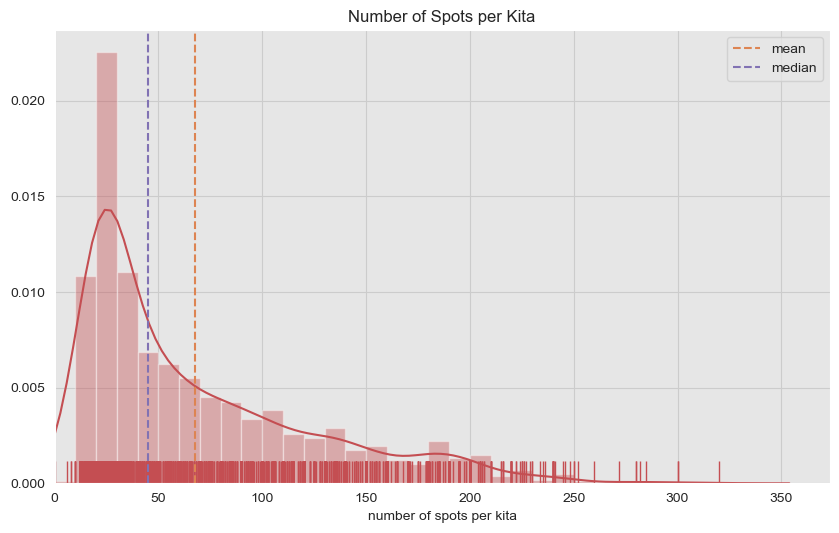

In [15]:
fig, ax = plt.subplots()
sns.distplot(a=kitas_df['spots'], rug=True, color=sns_c[3], ax=ax)
ax.axvline(x=kitas_df['spots'].describe()['mean'], color=sns_c[1], linestyle='--', label='mean')
ax.axvline(x=kitas_df['spots'].describe()['50%'], color=sns_c[4], linestyle='--', label='median')
ax.legend(loc='upper right')
ax.set(
    title='Number of Spots per Kita', 
     xlabel='number of spots per kita',
     xlim=(0, None)
);

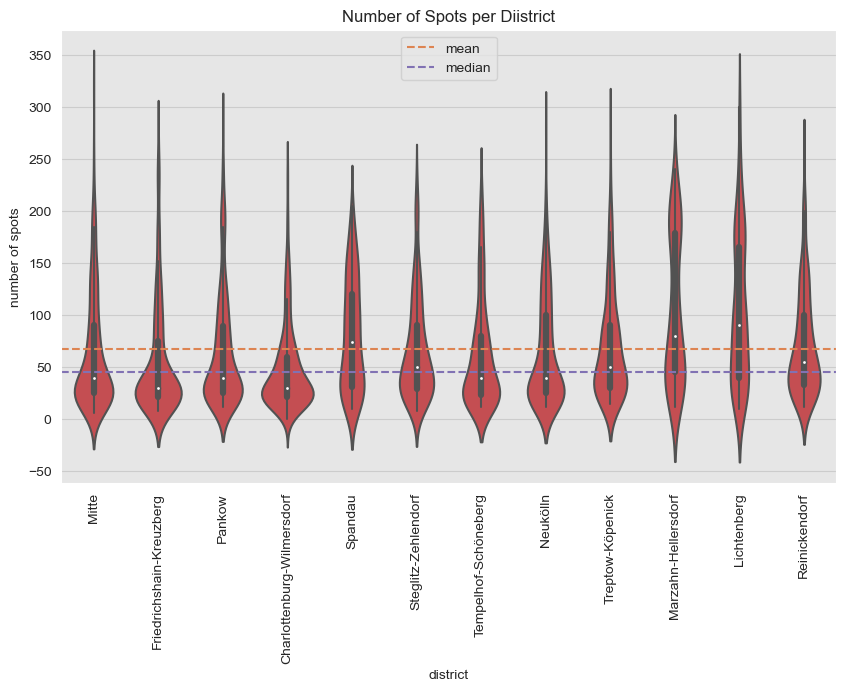

In [16]:
fig, ax = plt.subplots()

kitas_df \
    .pipe((sns.violinplot, 'data'), 
        x='district', 
        y='spots',
        color=sns_c[3],
        saturation=1.0,
        ax=ax
    )
ax.axhline(y=kitas_df['spots'].describe()['mean'], color=sns_c[1], linestyle='--', label='mean')
ax.axhline(y=kitas_df['spots'].describe()['50%'], color=sns_c[4], linestyle='--', label='median')
ax.tick_params(axis='x', labelrotation=90)
ax.legend(loc='upper center')
ax.set(
    title='Number of Spots per Diistrict', 
     ylabel='number of spots', 
);

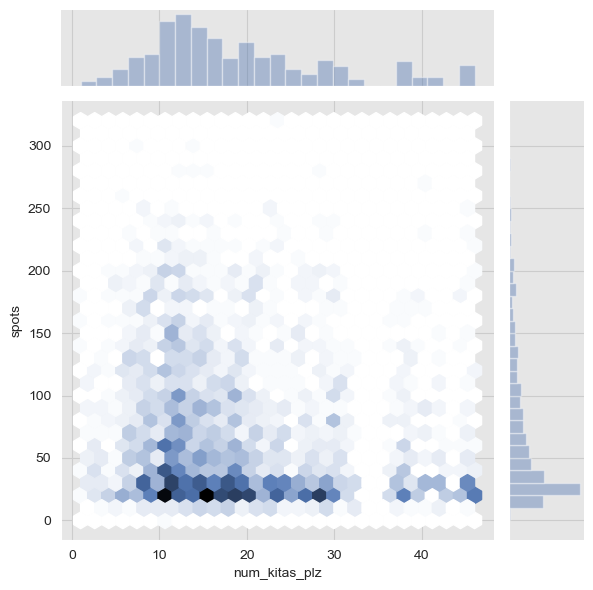

In [17]:
sns.jointplot(
    x='num_kitas_plz', 
    y='spots', 
    data=kitas_df, 
    kind='hex'
)

### Carriers

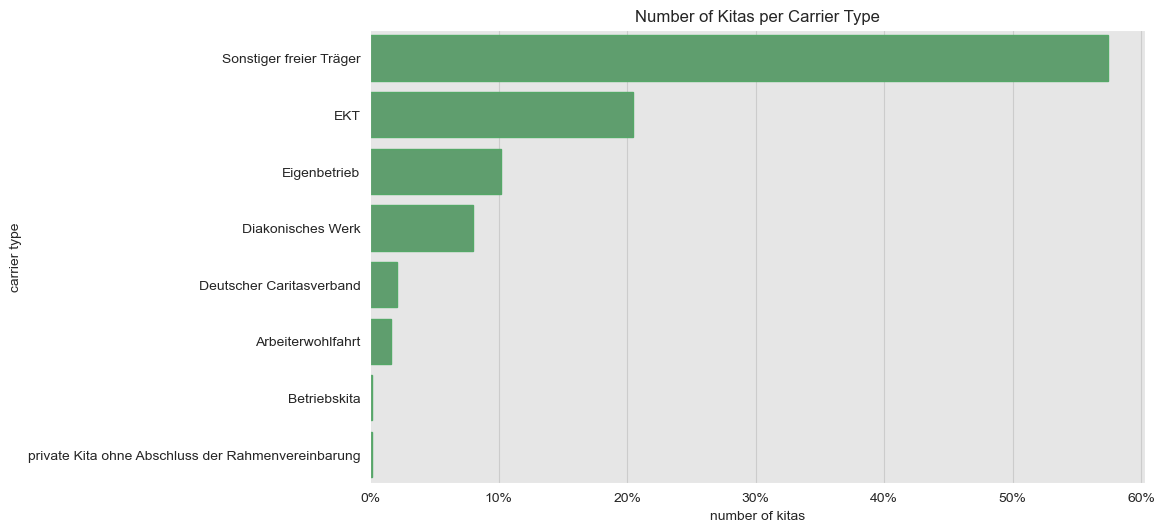

In [18]:
fig, ax = plt.subplots()

kitas_df \
    .groupby(['carrier_type']) \
    .agg(n=('id', 'count')) \
    .reset_index() \
    .sort_values('n', ascending=False) \
    .assign(share= lambda x: x['n'] / x['n'].sum()) \
    .pipe((sns.barplot, 'data'), 
        x='share', 
        y='carrier_type',
        color=sns_c[2],
        edgecolor=sns_c[2],
        ax=ax
    )
fmt = lambda y, _: f'{y :0.0%}'
ax.xaxis.set_major_formatter(mtick.FuncFormatter(fmt))
ax.set(
    title='Number of Kitas per Carrier Type', 
    xlabel='number of kitas', 
    ylabel='carrier type'
);

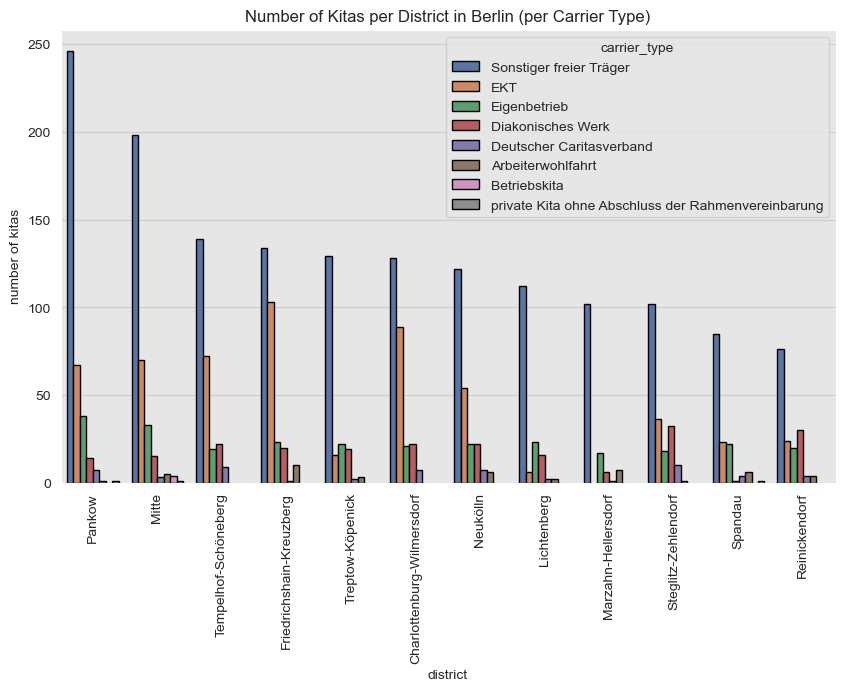

In [19]:
fig, ax = plt.subplots()

kitas_df \
    .groupby(['district', 'carrier_type']) \
    .agg(n=('id', 'count')) \
    .reset_index(drop=False) \
    .sort_values('n', ascending=False) \
    .pipe((sns.barplot, 'data'), 
        y='n', 
        x='district',
        hue='carrier_type',
        edgecolor='black',
        dodge=True,
        ax=ax
    )
ax.tick_params(axis='x', labelrotation=90)
ax.set(
    title='Number of Kitas per District in Berlin (per Carrier Type)', 
    xlabel='district', 
    ylabel='number of kitas'
);

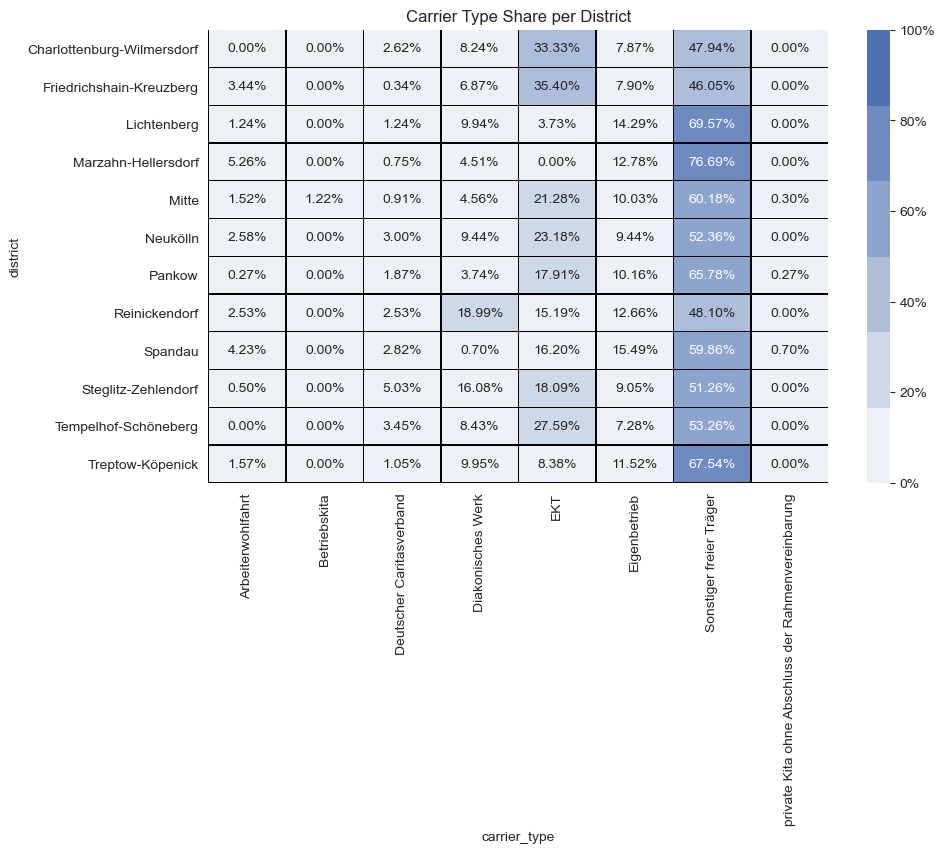

In [20]:
fig, ax = plt.subplots()

cmap = sns.light_palette(sns_c[0])

fmt = lambda y, _: f'{y :0.0%}'

kitas_df \
    .groupby(['district', 'carrier_type']) \
    .agg(n=('id', 'count')) \
    .reset_index(drop=False) \
    .assign(
        num_kitas_district = lambda x: x.groupby(['district'])['n'].transform(np.sum),
        share = lambda x: x['n'].div(x['num_kitas_district'])
    ) \
    .pivot(index='district', columns='carrier_type', values='share') \
    .fillna(0.0) \
    .pipe((sns.heatmap, 'data'), 
        vmin=0.0,
        vmax=1.0,
        cmap=cmap,
        linewidths=0.2, 
        linecolor='black',
        annot=True, 
        fmt='0.2%',
        cbar_kws={'format': mtick.FuncFormatter(fmt)},
        ax=ax
    )

ax.set(title='Carrier Type Share per District');

In [21]:
carrier_df = kitas_df \
    .groupby(['carrier_name']) \
    .agg(num_kitas=('name', pd.Series.nunique)) \
    .sort_values('num_kitas', ascending=False) \
    .assign(
        single_kita = lambda x: x['num_kitas'] < 2,
        share = lambda x: x['num_kitas'] / x['num_kitas'].sum(),
        cumsum_share = lambda x: x['share'].cumsum(),
        idx= lambda x: range(x.shape[0])
    )

In [22]:
carrier_df.groupby('single_kita').agg(n=('idx', 'count'))

,n
single_kita,
False,365
True,859


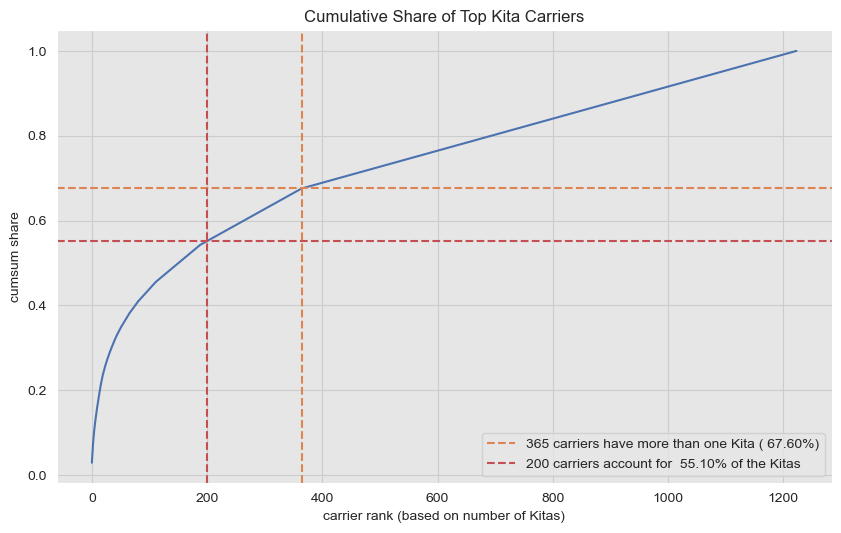

In [23]:
k = 200 
k_cumsum_share = carrier_df.query(f'idx == {k - 1}')['cumsum_share'].values[0]
idx_single_kita = carrier_df.query('single_kita').iloc[0]['idx']
cumsum_share_single_kita = carrier_df.query('single_kita').iloc[0]['cumsum_share']

fig, ax = plt.subplots()
sns.lineplot(x='idx', y='cumsum_share', data=carrier_df, color=sns_c[0], ax=ax)
ax.axvline(x=idx_single_kita, color=sns_c[1], linestyle='--', label=f'{idx_single_kita} carriers have more than one Kita ({cumsum_share_single_kita: 0.2%})')
ax.axhline(y=cumsum_share_single_kita, color=sns_c[1], linestyle='--')
ax.axvline(x=k, color=sns_c[3], linestyle='--', label=f'{k} carriers account for {k_cumsum_share: 0.2%} of the Kitas')
ax.axhline(y=k_cumsum_share , color=sns_c[3], linestyle='--')
ax.legend(loc='lower right')
ax.set(
    title='Cumulative Share of Top Kita Carriers', 
    xlabel='carrier rank (based on number of Kitas)',
    ylabel='cumsum share'
);

In [24]:
kitas_df = pd.merge(
    left=kitas_df, 
    right=carrier_df['single_kita'].reset_index(), 
    on='carrier_name', 
    how='left'
)

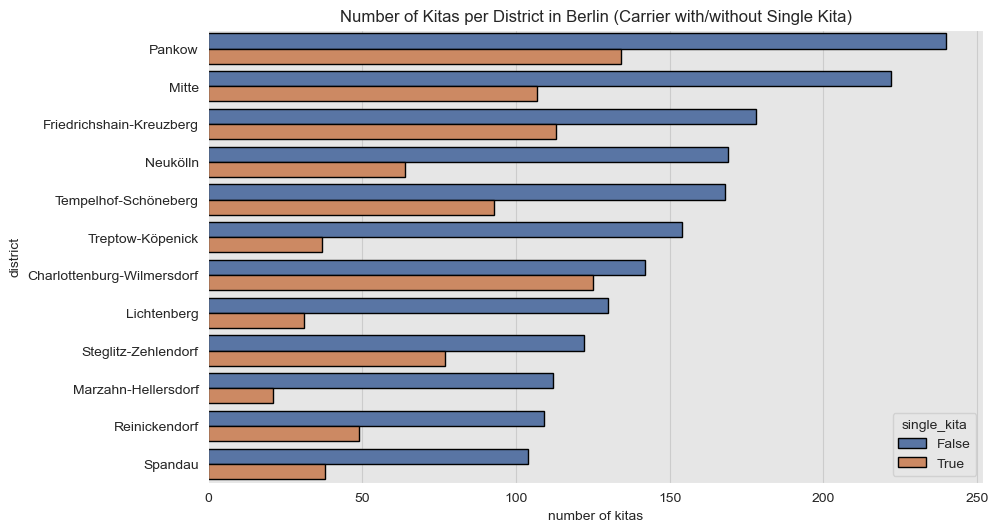

In [25]:
fig, ax = plt.subplots()

kitas_df \
    .groupby(['district', 'single_kita']) \
    .agg(n=('id', 'count')) \
    .reset_index(drop=False) \
    .sort_values('n', ascending=False) \
    .pipe((sns.barplot, 'data'), 
        x='n', 
        y='district',
        hue='single_kita',
        edgecolor='black',
        ax=ax
    )
ax.set(
    title='Number of Kitas per District in Berlin (Carrier with/without Single Kita)', 
    xlabel='number of kitas', 
    ylabel='district'
);